Set Play Shots - Expected Goal Model - Model Evaluation - GBM

In [1]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from expected_score_model.config import goal_set_shots_file_path
from expected_score_model.domain.contracts.modelling_data_contract import ModellingDataContract
from expected_score_model.domain.modelling.supermodel import SuperXGBClassifier
from expected_score_model.domain.modelling.model_evaluation import XGBClassifierEvaluator

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


New Model

In [2]:
new_version = 8
model_name = "expected_goal_set"
model_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models"
preproc_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/preprocessors"

Comparison Model

In [3]:
old_version = new_version - 1
compare_train_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/train_predictions_"+model_name+"_v"+str(old_version)+".csv"
compare_test_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/test_predictions_"+model_name+"_v"+str(old_version)+".csv"

Response

In [4]:
RESPONSE = ModellingDataContract.RESPONSE_GOAL

Features

In [6]:
FEATURES = ModellingDataContract.feature_list_set_goal

Load Data

In [7]:
df_modelling = pd.read_csv(goal_set_shots_file_path)
df_modelling.tail()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Season,Goal,Behind,Miss,Score,Event_Type1,Set_Shot,x0,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Visible_Goal_Angle,ballUp,centreBounce,kickIn,possGain,throwIn,GoalTrainingSet,GoalTestSet,GoalValidationSet
16981,186,possGain,behind,1447.0,4,185,224.0,Collingwood,Collingwood,Bobby Hill,Bobby_Hill,Kick,32.0,0.0,ineffective,True,NaN,141,160,Collingwood,Brisbane Lions,right,2023F4_Collingwood_BrisbaneLions,2023F4,NaN,2023.0,0,1,0,1,Uncontested Mark,True,32.0,48.000000,0.000000,0.133929,False,False,False,True,False,True,False,False
16982,196,possGain,behind,1527.0,4,425,476.0,Brisbane Lions,Brisbane Lions,Joe Daniher,Joe_Daniher,Kick,50.0,-19.0,ineffective,True,NaN,141,160,Collingwood,Brisbane Lions,right,2023F4_Collingwood_BrisbaneLions,2023F4,NaN,2023.0,0,1,0,1,Mark On Lead,True,50.0,35.510562,0.564569,0.153507,False,False,False,True,False,False,False,True
16983,210,throwIn,behind,1610.0,4,804,841.0,Brisbane Lions,Brisbane Lions,Eric Hipwood,Eric_Hipwood,Kick,36.0,37.0,ineffective,True,NaN,141,160,Collingwood,Brisbane Lions,right,2023F4_Collingwood_BrisbaneLions,2023F4,NaN,2023.0,0,1,0,1,Uncontested Mark,True,36.0,57.489129,0.699193,0.085469,False,False,False,False,True,True,False,False
16984,224,possGain,goal,1740.0,4,1290,1348.0,Collingwood,Collingwood,Steele Sidebottom,Steele_Sidebottom,Kick,37.0,34.0,effective,True,NaN,141,160,Collingwood,Brisbane Lions,right,2023F4_Collingwood_BrisbaneLions,2023F4,NaN,2023.0,1,0,0,6,Mark On Lead,True,37.0,54.817880,0.669043,0.091894,False,False,False,True,False,True,False,False
16985,233,ballUp,goal,1811.0,4,1591,1629.0,Brisbane Lions,Brisbane Lions,Joe Daniher,Joe_Daniher,Kick,54.0,2.0,effective,True,NaN,141,160,Collingwood,Brisbane Lions,right,2023F4_Collingwood_BrisbaneLions,2023F4,NaN,2023.0,1,0,0,6,Uncontested Mark,True,54.0,26.076810,0.076772,0.248447,True,False,False,False,False,False,False,True


In [8]:
df_modelling[['ballUp', 'centreBounce', 'kickIn', 'possGain', 'throwIn']] = pd.get_dummies(df_modelling['Initial_State'])

In [9]:
training_data = df_modelling[df_modelling[RESPONSE+"TrainingSet"]]
test_data = df_modelling[df_modelling[RESPONSE+"TestSet"]]
cal_data = df_modelling[df_modelling[RESPONSE+"ValidationSet"]]

In [10]:
X_train, y_train = training_data.drop(columns=[RESPONSE]), training_data[RESPONSE]
X_test, y_test = test_data.drop(columns=[RESPONSE]), test_data[RESPONSE]
X_cal, y_cal = cal_data.drop(columns=[RESPONSE]), cal_data[RESPONSE]

In [11]:
X_test.head()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Season,Behind,Miss,Score,Event_Type1,Set_Shot,x0,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Visible_Goal_Angle,ballUp,centreBounce,kickIn,possGain,throwIn,GoalTrainingSet,GoalTestSet,GoalValidationSet
1,28,possGain,behind,295.0,1,859,911.0,Sydney,Sydney,Sam Reid,Sam_Reid,Kick,52.0,35.0,ineffective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,1,0,1,Contested Mark,True,52.0,43.600459,0.931882,0.088007,False,False,False,True,False,False,True,False
17,168,centreBounce,miss,1480.0,3,1850,1899.0,Brisbane Lions,Brisbane Lions,Eric Hipwood,Eric_Hipwood,Kick,52.0,-31.0,clanger,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,0,1,0,Mark On Lead,True,52.0,40.459857,0.872894,0.102289,False,True,False,False,False,False,True,False
19,189,kickIn,goal,1639.0,4,390,439.0,Brisbane Lions,Brisbane Lions,Lincoln McCarthy,Lincoln_McCarthy,Kick,55.0,-2.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,0,0,6,Free For,True,55.0,23.086793,0.086738,0.281582,False,False,True,False,False,False,True,False
25,11,centreBounce,goal,103.0,1,190,249.0,Western Bulldogs,Western Bulldogs,Aaron Naughton,Aaron_Naughton,Kick,54.0,-18.0,effective,True,NaN,141,160,Collingwood,Western Bulldogs,right,202101_Collingwood_WesternBulldogs,202101,2021.0,NaN,0,0,6,Mark On Lead,True,54.0,31.622777,0.605545,0.168122,False,True,False,False,False,False,True,False
36,139,possGain,behind,1190.0,3,205,256.0,Collingwood,Collingwood,Brody Mihocek,Brody_Mihocek,Kick,50.0,-30.0,ineffective,True,NaN,141,160,Collingwood,Western Bulldogs,right,202101_Collingwood_WesternBulldogs,202101,2021.0,NaN,1,0,1,Uncontested Mark,True,50.0,42.426407,0.785398,0.107277,False,False,False,True,False,False,True,False


Preprocess Data

In [12]:
# preprocessor = DataPreprocessor()
# preprocessor.fit(X_train)

# X_train_preproc = preprocessor.transform(X_train)
# X_test_preproc = preprocessor.transform(X_test)

In [13]:
X_train_preproc = X_train[FEATURES]
X_test_preproc = X_test[FEATURES]

In [14]:
X_train_preproc.shape, X_test_preproc.shape

((10870, 9), (3398, 9))

In [15]:
X_train_preproc.head()

,x0,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Visible_Goal_Angle,ballUp,centreBounce,kickIn,possGain,throwIn
0,46.0,52.009614,0.908067,0.075999,False,False,True,False,False
2,45.0,36.674242,0.451453,0.158231,False,False,False,True,False
4,33.0,46.572524,0.260602,0.133410,False,True,False,False,False
5,52.0,44.407207,0.945311,0.084822,False,False,False,True,False
6,47.0,46.754679,0.845930,0.091187,False,False,False,True,False


In [16]:
X_test_preproc.head()

,x0,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Visible_Goal_Angle,ballUp,centreBounce,kickIn,possGain,throwIn
1,52.0,43.600459,0.931882,0.088007,False,False,False,True,False
17,52.0,40.459857,0.872894,0.102289,False,True,False,False,False
19,55.0,23.086793,0.086738,0.281582,False,False,True,False,False
25,54.0,31.622777,0.605545,0.168122,False,True,False,False,False
36,50.0,42.426407,0.785398,0.107277,False,False,False,True,False


Load Model

In [17]:
super_xgb = joblib.load(model_file_path + "/" + model_name + "_v" + str(new_version) + ".joblib")

In [18]:
super_xgb.xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3996090457164005, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.015562976956132275, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.6450950877705423, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=18, max_leaves=None,
              min_child_weight=10, missing=nan,
              monotone_constraints={'Angle_to_Middle_Goal': -1,
                                    'Distance_to_Middle_Goal': -1,
                                    'Visible_Goal_Angle': 1, 'x0': -1},
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Get Predictions

In [19]:
train_preds = super_xgb.predict(X_train_preproc)
test_preds = super_xgb.predict(X_test_preproc)

In [20]:
train_probas = super_xgb.predict_proba(X_train_preproc)[:, 1]
test_probas = super_xgb.predict_proba(X_test_preproc)[:, 1]

In [21]:
train_cal_probas = super_xgb.predict_proba(X_train_preproc, calibrate=True)
test_cal_probas = super_xgb.predict_proba(X_test_preproc, calibrate=True)

Compare Model

In [22]:
compare_train_data = pd.read_csv(compare_train_predictions_file_path)
compare_test_data = pd.read_csv(compare_test_predictions_file_path)

In [23]:
compare_train_data = compare_train_data.rename(columns = {'xgb_preds':'old_preds',
                                                          'xgb_probas':'old_probas'})
compare_test_data = compare_test_data.rename(columns = {'xgb_preds':'old_preds',
                                                        'xgb_probas':'old_probas'})

In [24]:
training_data.shape, compare_train_data.shape

((10870, 44), (7076, 16))

In [25]:
training_data = pd.merge(training_data, compare_train_data[["Match_ID", "Chain_Number", "Order", 'old_preds', 'old_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])
test_data = pd.merge(test_data, compare_test_data[["Match_ID", "Chain_Number", 'Order', 'old_preds', 'old_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])

Evaluate Model

In [26]:
training_data['xgb_preds'] = train_preds
training_data['xgb_probas'] = train_probas
training_data['xgb_cal_probas'] = train_cal_probas

train_xgb_evals = XGBClassifierEvaluator(model = super_xgb.xgb_model,
                                       data = training_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_cal_probas",
                                       expected_label_name = "xgb_preds",
                                    #    compare_name='xgb_probas',
                                    #    compare_label_name="xgb_preds"
                                       )

In [27]:
test_data['xgb_preds'] = test_preds
test_data['xgb_probas'] = test_probas
test_data['xgb_cal_probas'] = test_cal_probas

test_xgb_evals = XGBClassifierEvaluator(model = super_xgb.xgb_model,
                                       data = test_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_cal_probas",
                                       expected_label_name = "xgb_preds",
                                    #    compare_name = "xgb_probas",
                                    #    compare_label_name="xgb_preds"
                                       )

Model Averages

In [28]:
training_data[[RESPONSE, 'xgb_probas', 'xgb_cal_probas']].describe()

,Goal,xgb_probas,xgb_cal_probas
count,10870.000000,10870.000000,10870.000000
mean,0.538546,0.539260,0.557218
std,0.498535,0.207041,0.188735
min,0.000000,0.117564,0.192286
25%,0.000000,0.374220,0.408302
50%,1.000000,0.500826,0.513494
75%,1.000000,0.703130,0.697956
max,1.000000,0.984329,0.987214


In [29]:
test_data[[RESPONSE, 'xgb_probas', 'xgb_cal_probas']].describe()

,Goal,xgb_probas,xgb_cal_probas
count,3398.000000,3398.000000,3398.000000
mean,0.537081,0.537232,0.555308
std,0.498697,0.206453,0.187783
min,0.000000,0.122381,0.196933
25%,0.000000,0.368013,0.403264
50%,1.000000,0.502775,0.515162
75%,1.000000,0.700255,0.695156
max,1.000000,0.985038,0.987860


Plots

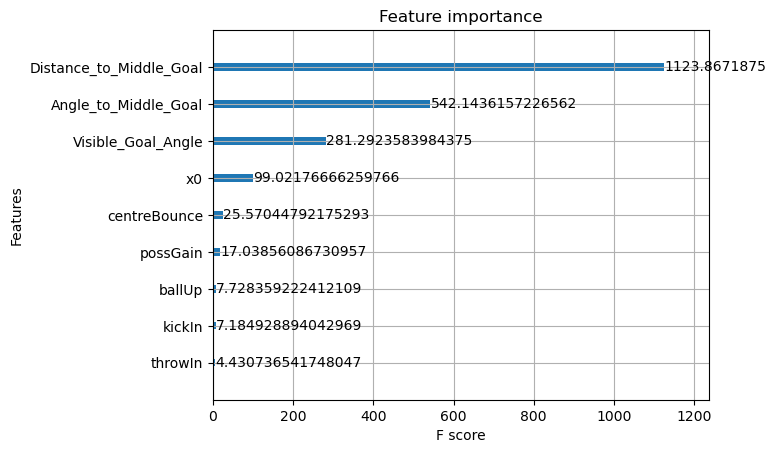

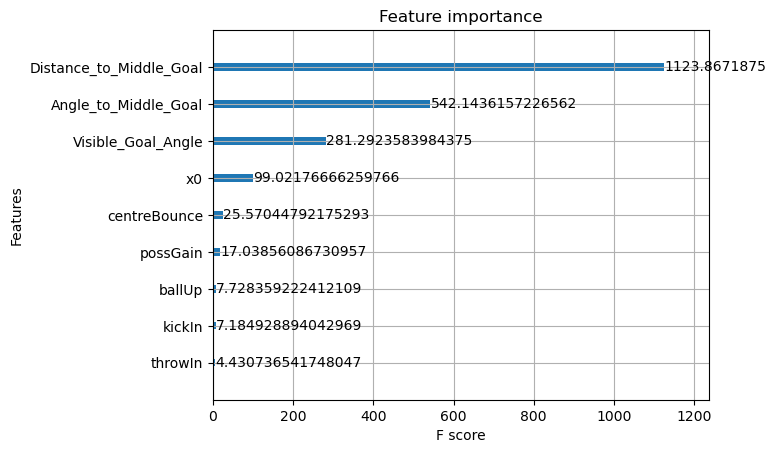

In [30]:
train_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")
test_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

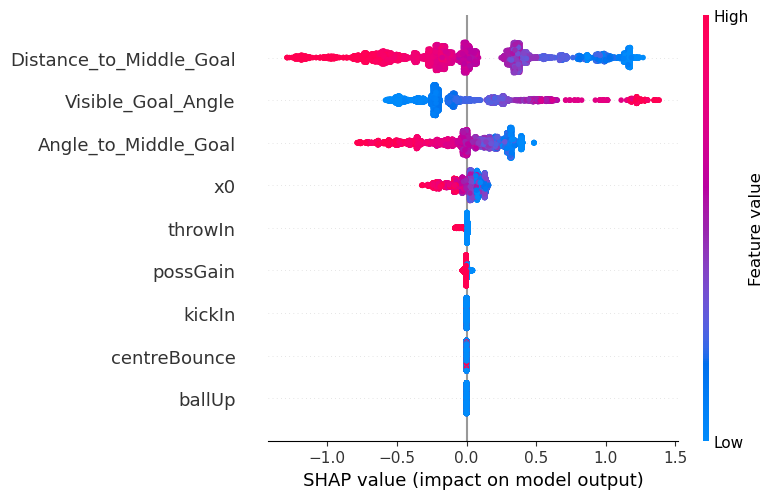

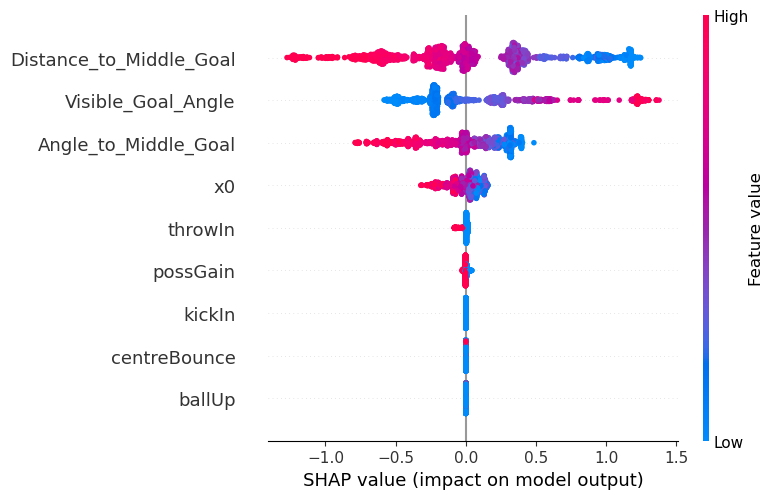

In [97]:
train_xgb_evals.plot_shap_summary_plot()
test_xgb_evals.plot_shap_summary_plot()

In [98]:
top_features = test_xgb_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['Distance_to_Middle_Goal',
 'Visible_Goal_Angle',
 'Angle_to_Middle_Goal',
 'x0',
 'throwIn',
 'possGain',
 'ballUp',
 'centreBounce',
 'kickIn']

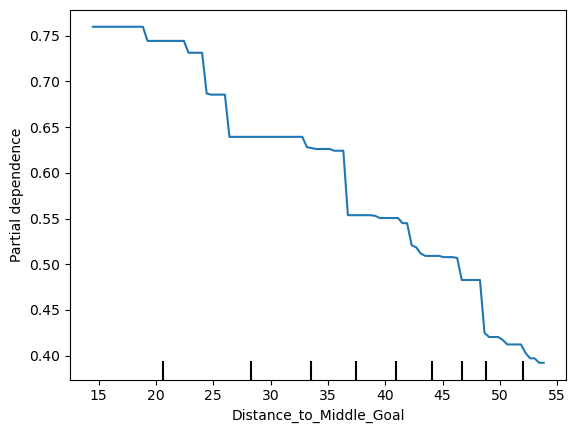

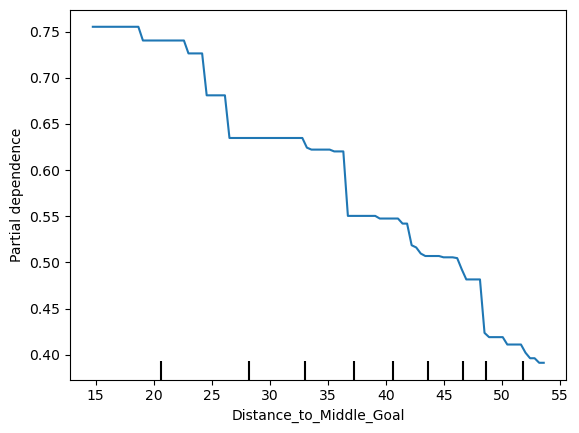

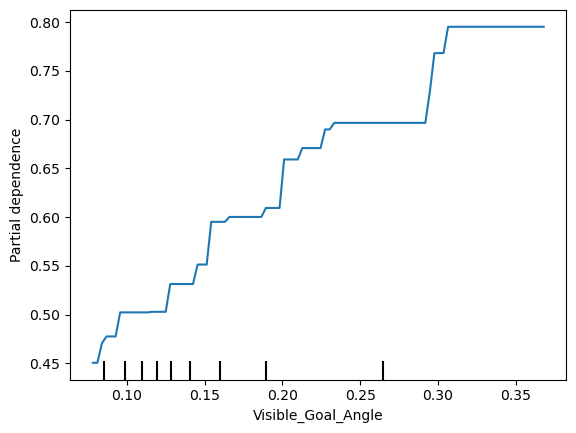

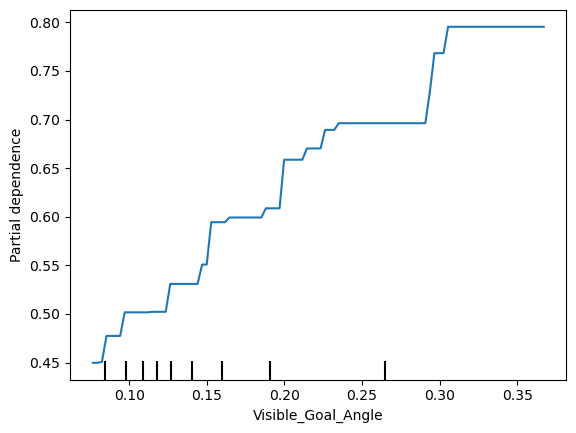

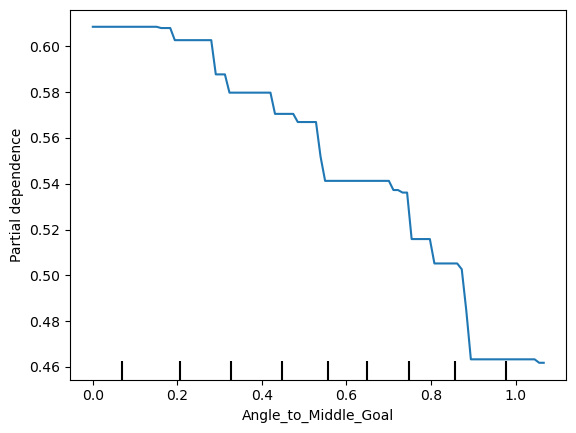

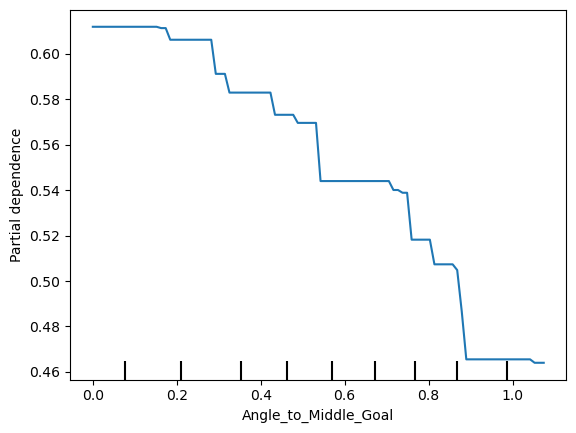

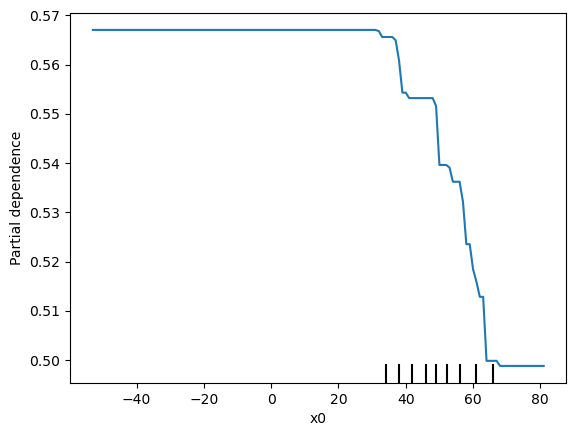

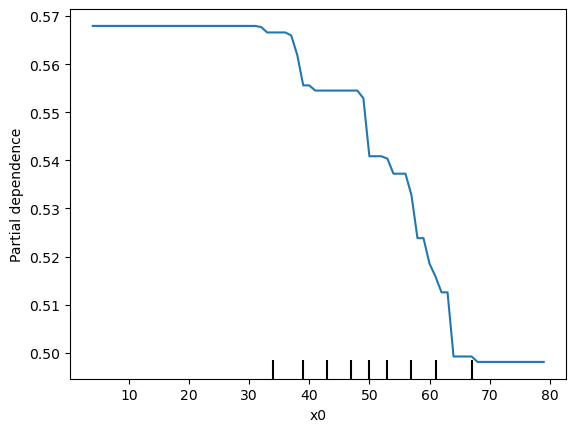

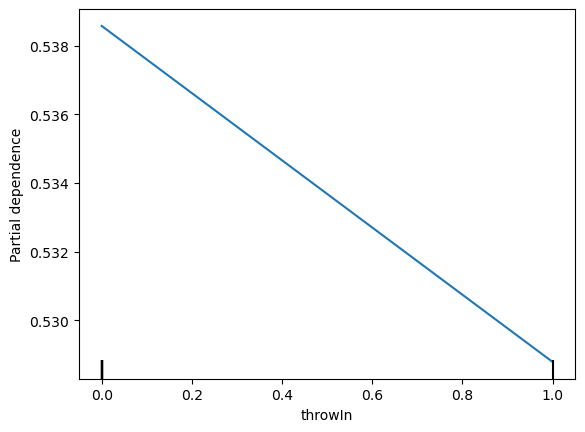

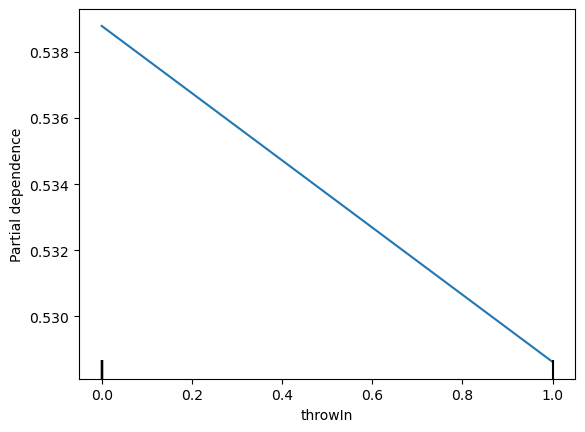

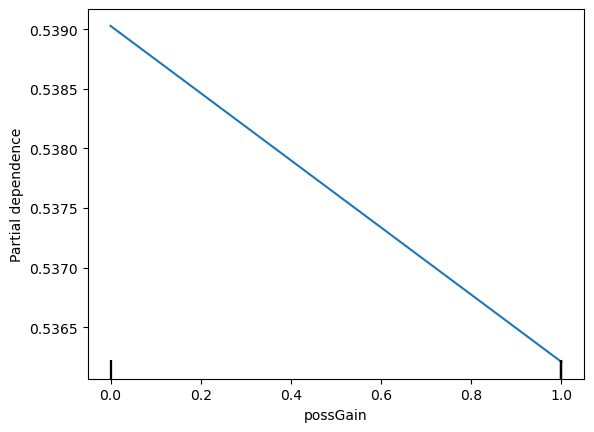

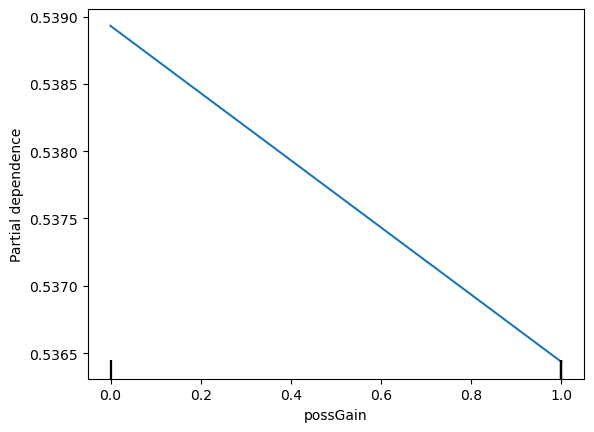

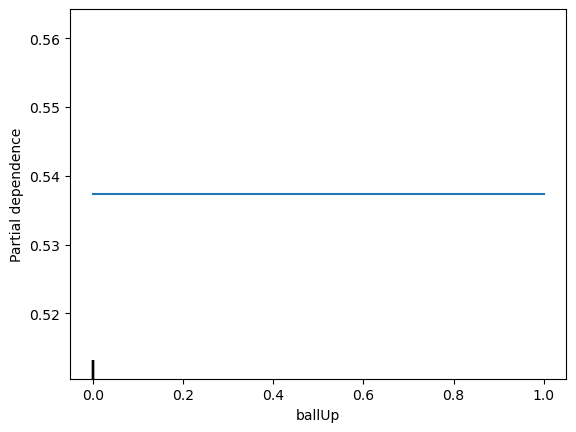

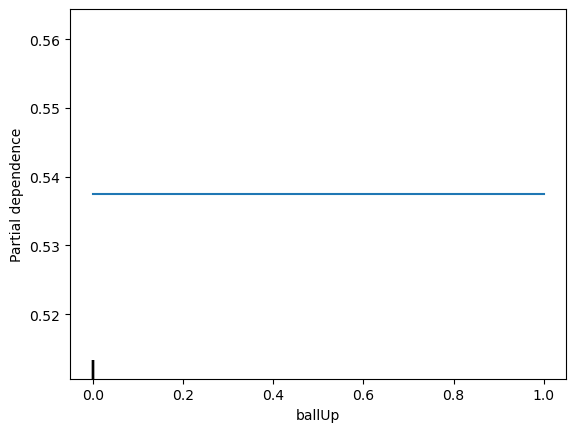

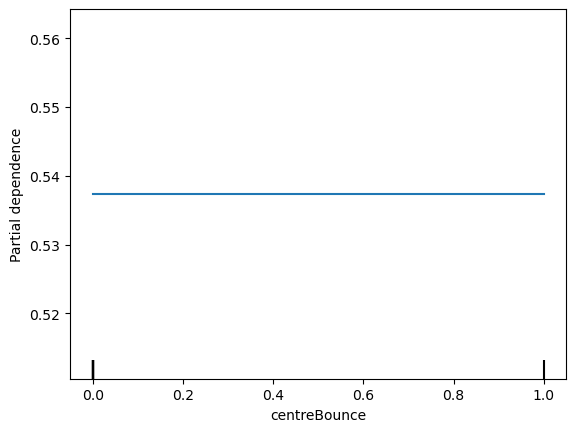

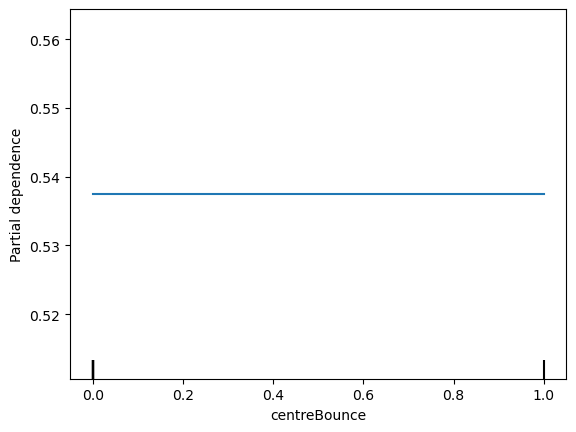

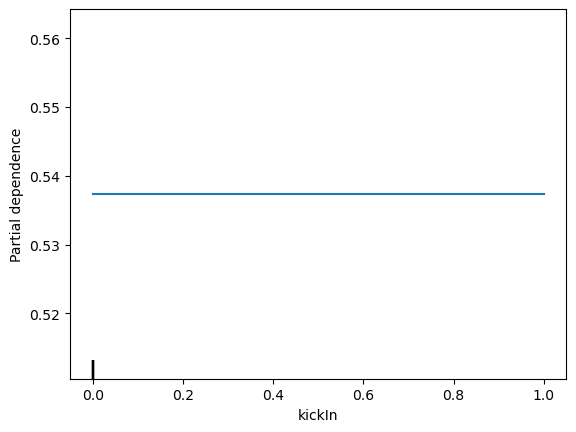

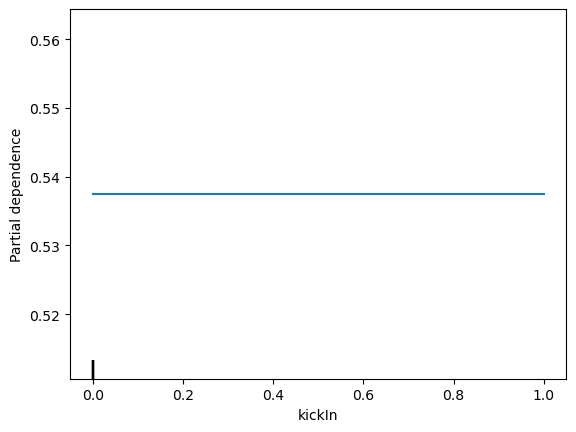

In [99]:
for col in top_10_features:
    train_xgb_evals.plot_pdp([col])
    test_xgb_evals.plot_pdp([col])

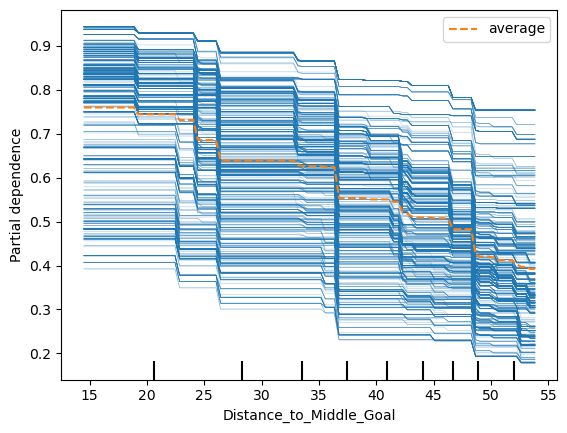

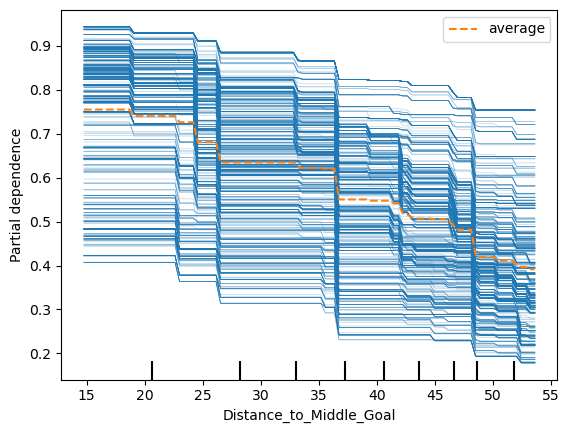

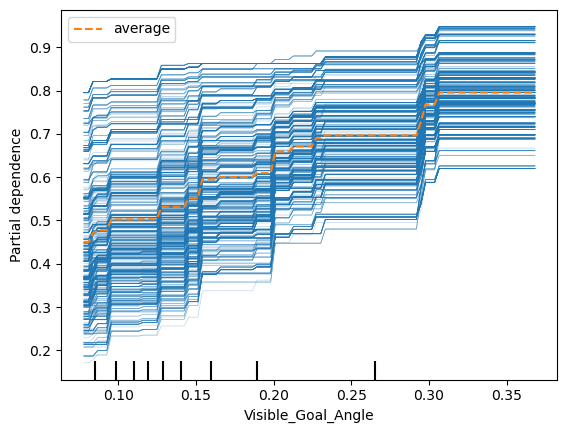

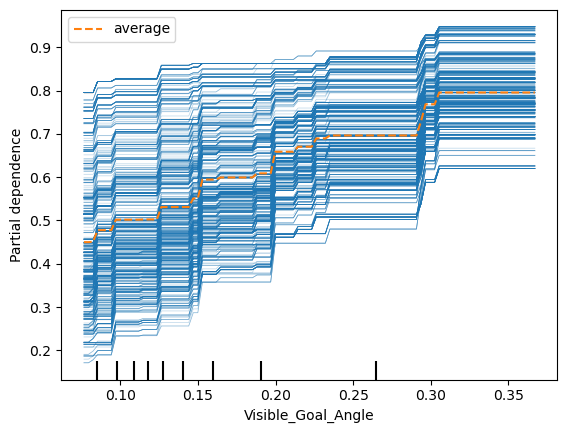

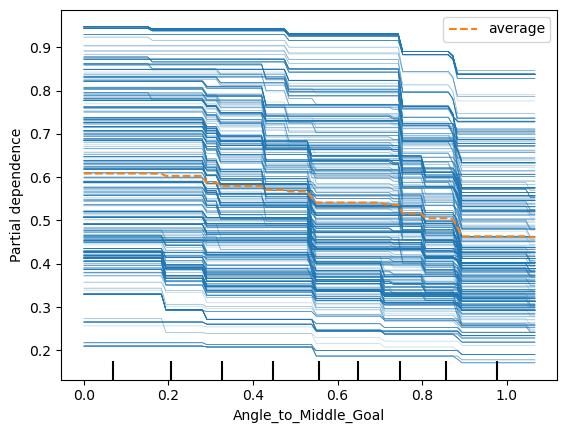

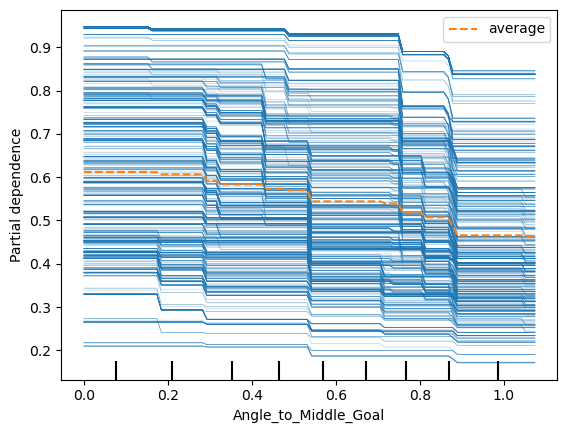

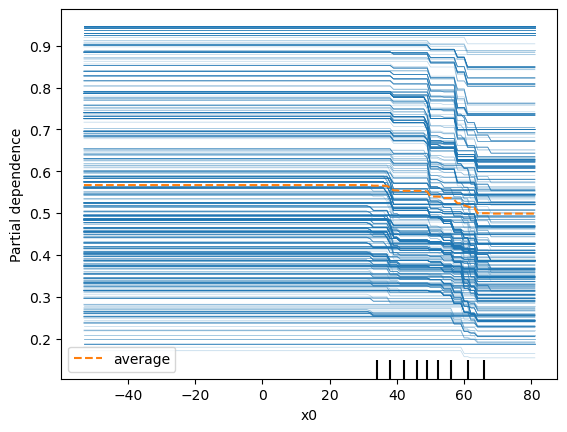

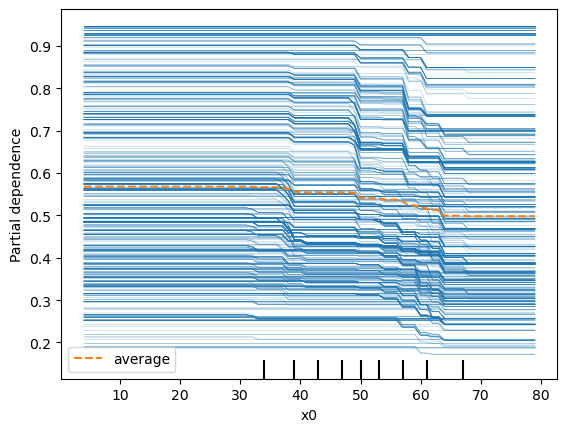

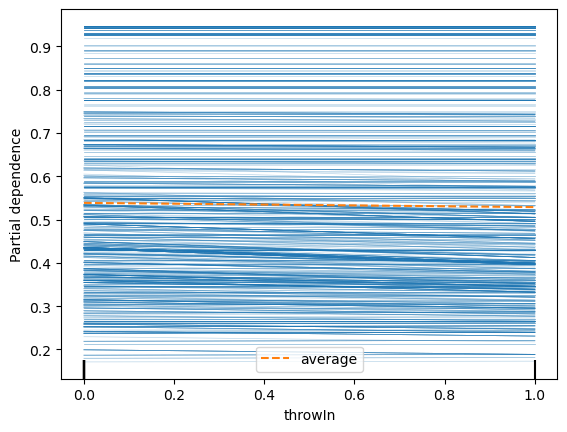

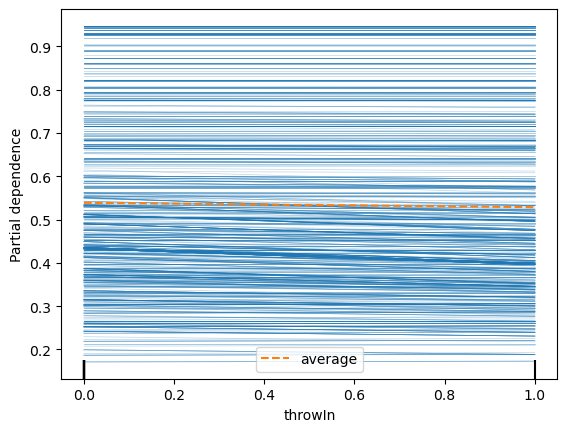

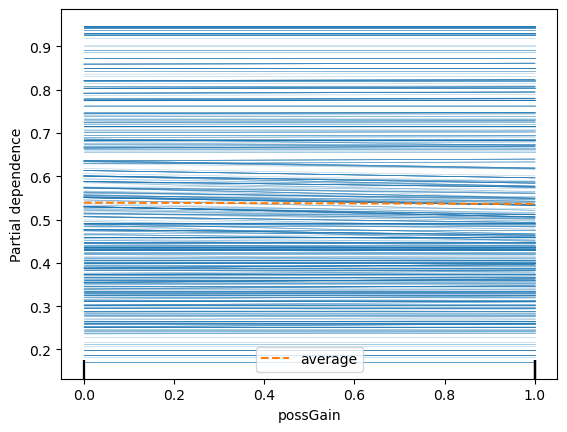

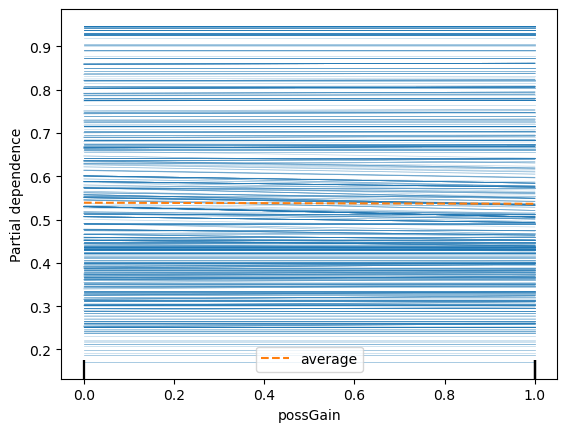

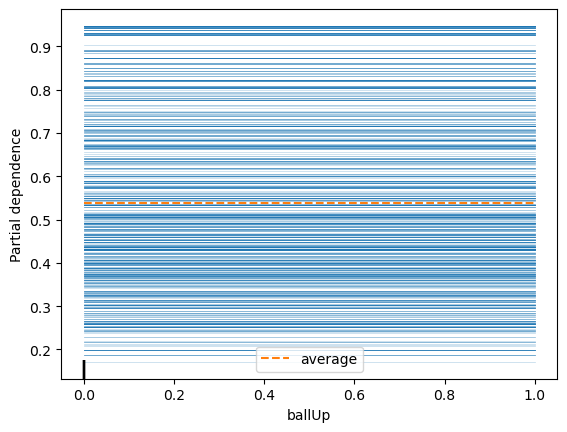

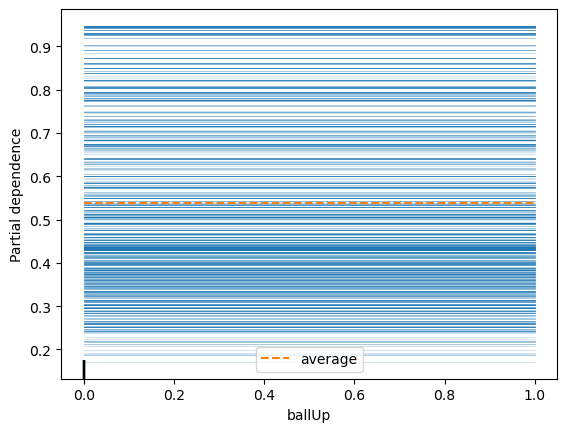

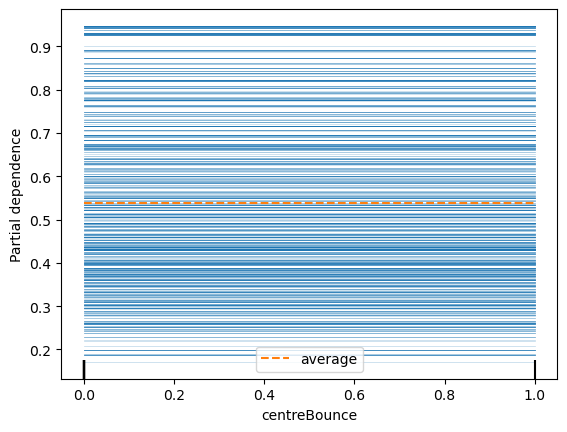

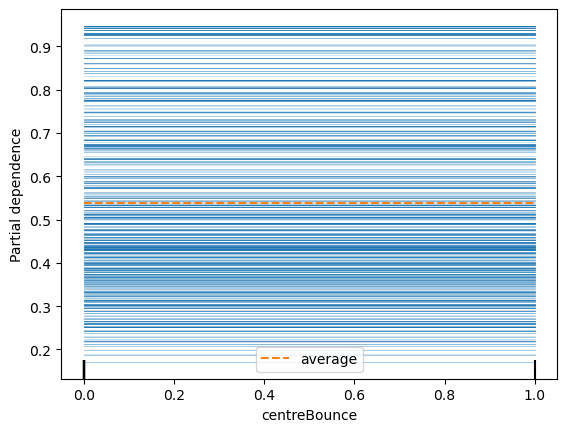

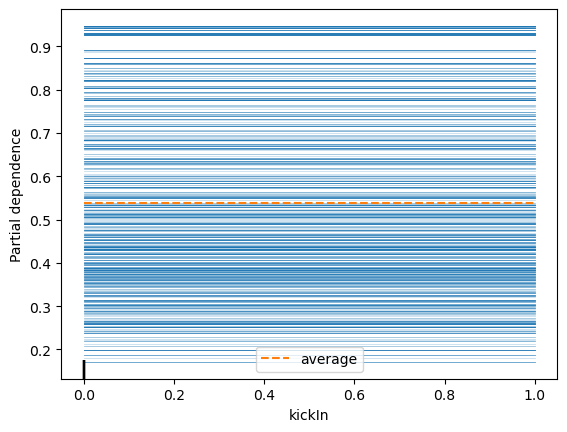

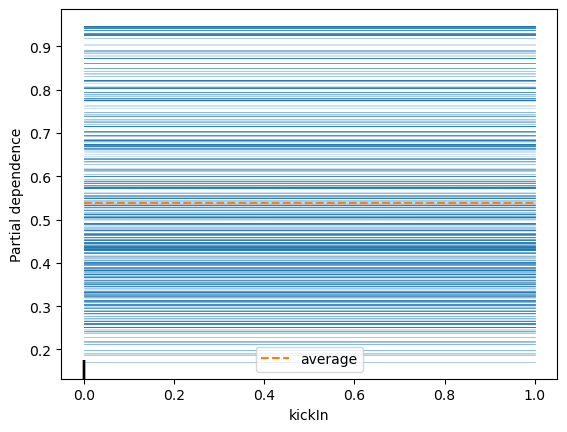

In [100]:
for col in top_10_features:
    train_xgb_evals.plot_ice([col])
    test_xgb_evals.plot_ice([col])

In [31]:
for col in top_10_features:
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

NameError: name 'top_10_features' is not defined

Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [32]:
train_xgb_evals.get_log_loss(), test_xgb_evals.get_log_loss()

Expected Log-Loss: 	0.5936
Expected Log-Loss: 	0.5981


(0.5935934545601244, 0.5980854296480432)

In [33]:
train_xgb_evals.get_brier_score_loss(), test_xgb_evals.get_brier_score_loss()

Expected Brier Score: 	0.2058
Expected Brier Score: 	0.2079


(0.20582222778349885, 0.20792909274121205)

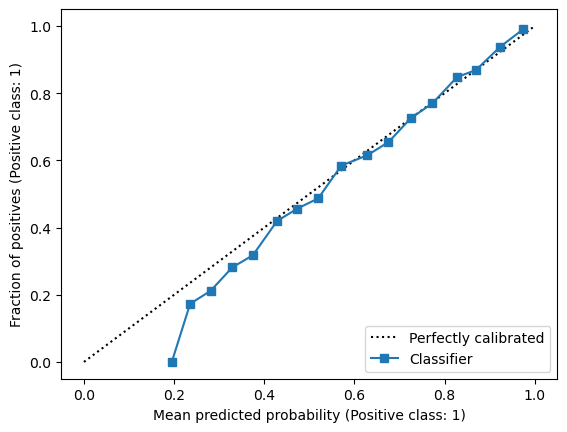

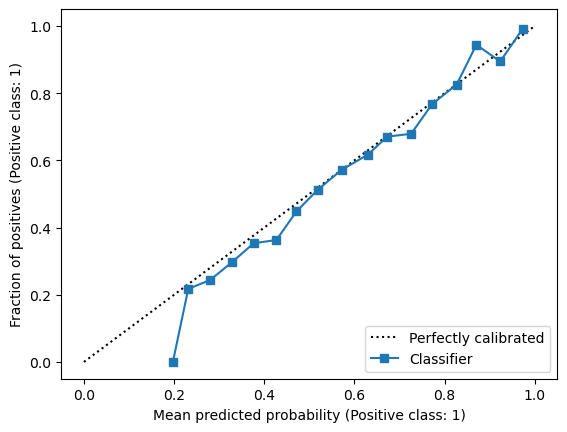

In [34]:
train_xgb_evals.display_calibration_curve(nbins=20)
test_xgb_evals.display_calibration_curve(nbins=20)